In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

could not import shapefile, PyShp has not been installed, no shapefile reading capabilities enabled


In [2]:
md = loadmodel('./Models/SAtoES_inversion.nc')
#plotmodel(md, 'data', md.mask.ice_levelset)
md.levelset.spclevelset = np.nan * np.ones((md.mesh.numberofvertices))
pos = md.mesh.vertexonboundary == 1
#pos = np.where(md.mesh.vertexonboundary)
md.levelset.spclevelset[pos] = md.mask.ice_levelset[pos]
md.levelset.migration_max = 1e10
#plotmodel(md, 'data', md.mask.ice_levelset)

Opening ./Models/SAtoES_inversion.nc for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.solutionstep
empty init


In [3]:
# defining thermal and sub. discharge at every ISSM mesh node 

# load raster of basins
ds = gdal.Open('./Cheat_matfiles/tidewaterbasins_rignotid.mat_tidewaterbasins.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
basins_array = rb.ReadAsArray()

gt = ds.GetGeoTransform()
ulx, xres, xskew, uly, yskew, yres  = gt
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
x = np.arange(ulx, lrx,  xres)
y = np.arange(lry, uly, -yres)


In [4]:
# interpolate basin to each mesh node 
px = np.array( ((md.mesh.x - gt[0]) / gt[1]).astype(int) )
py = np.array( ((md.mesh.y - gt[3]) / gt[5]).astype(int) )

basins_mesh = basins_array[py.astype(int), px.astype(int)]

/efs/issm/issm/trunk-jpl-denis/src/m/plot/plotmodel.py:123: MatplotlibDeprecationWarning: 
The 'add_all' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'add_all', they should be passed as keyword, not positionally.
  axgrid = ImageGrid(


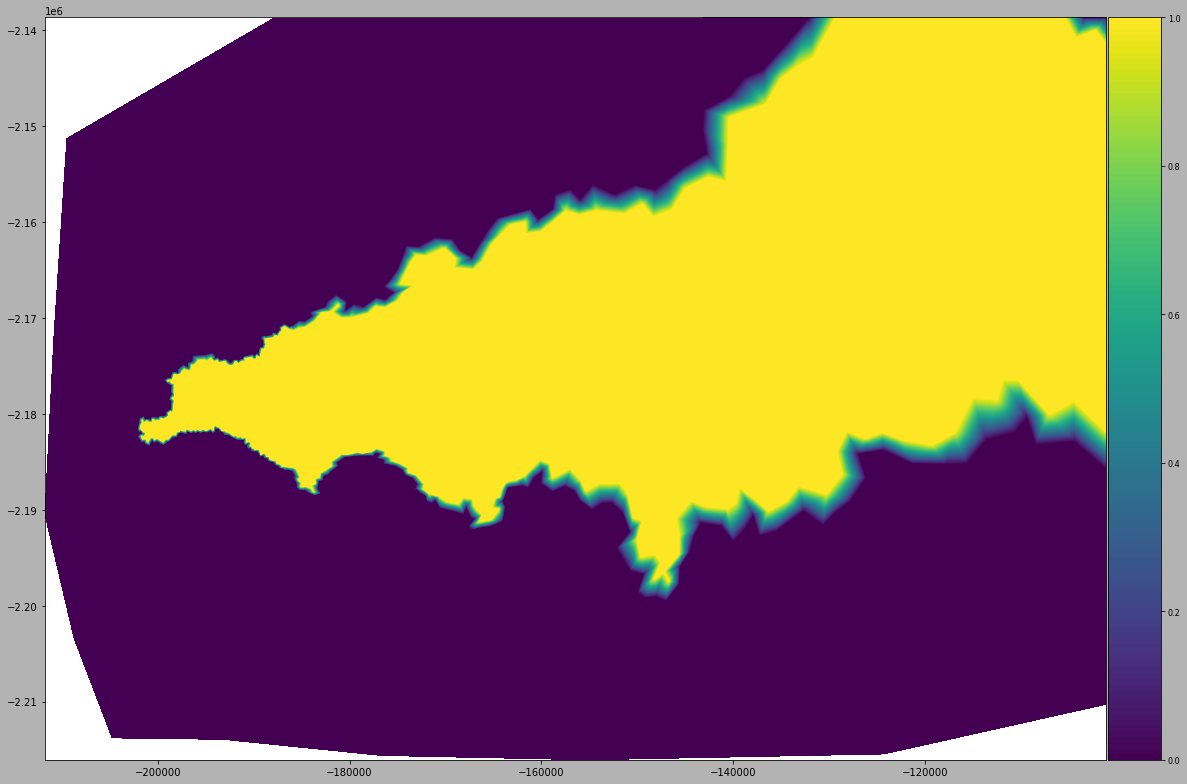

In [5]:
basins_mesh[basins_mesh==-9999] = 0
fig = plt.figure(figsize=(20,20))
plotmodel(md, 'data', (basins_mesh==13).astype(int)) #, 'edgecolor', 'k') #, 'caxis', [52, 54])
# basins_mesh == basin_id
#md.frontalforcing.thermal = basins_mesh==glacier_id

## Load discharge and thermal forcing

In [6]:
from scipy_io_utils import *

glacier_list = list()
m = loadmat('./Cheat_matfiles/glacier0013.mat')
glacier0013 = m['glacier0013']
m = loadmat('./Cheat_matfiles/glacier0052.mat')
glacier0052 = m['glacier0052']
m = loadmat('./Cheat_matfiles/glacier0053.mat')
glacier0053 = m['glacier0053']
m = loadmat('./Cheat_matfiles/glacier0090.mat')
glacier0090 = m['glacier0090']

In [7]:
# Thermal forcing
t = glacier0013['EN4']['t']
TF = glacier0013['EN4']['TF']

# Discharge
t = glacier0013['RACMO']['Q']
Q = glacier0013['RACMO']['Q']

In [8]:
from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()
md.frontalforcings.thermalforcing = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['EN4']['TF'])) )
md.frontalforcings.subglacial_discharge = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['RACMO']['Q'])) )

In [9]:
# Assign forcings to correct node 

# step 1: find which nodes belong to basin 13 using basin_mesh
get_indexes = lambda basins_mesh, xs: [i for (y, i) in zip(xs, range(len(xs))) if basins_mesh == y]
glacier13_nodes = get_indexes(13,basins_mesh)
glacier52_nodes = get_indexes(52,basins_mesh)
glacier53_nodes = get_indexes(53,basins_mesh)
glacier90_nodes = get_indexes(90,basins_mesh)

# NOTE: Denis combined steps 2 and 3: we select the rows and set to the TF time series
# step 2: select() rows from frontalforcings.thermal that correspond to step 1 nodes
md.frontalforcings.thermalforcing[glacier13_nodes,:] = glacier0013['EN4']['TF']
md.frontalforcings.thermalforcing[glacier52_nodes,:] = glacier0052['EN4']['TF']
md.frontalforcings.thermalforcing[glacier53_nodes,:] = glacier0053['EN4']['TF']
md.frontalforcings.thermalforcing[glacier90_nodes,:] = glacier0090['EN4']['TF']

# step 2: select() rows from frontalforcings.subglacial_discharge that correspond to step 1 nodes
md.frontalforcings.subglacial_discharge[glacier13_nodes,:] = glacier0013['RACMO']['Q']
md.frontalforcings.subglacial_discharge[glacier52_nodes,:] = glacier0052['RACMO']['Q']
md.frontalforcings.subglacial_discharge[glacier53_nodes,:] = glacier0053['RACMO']['Q']
md.frontalforcings.subglacial_discharge[glacier90_nodes,:] = glacier0090['RACMO']['Q']

# NOTE: And now, set the last row to the time
md.frontalforcings.thermalforcing[-1,:] = glacier0013['EN4']['t']
md.frontalforcings.subglacial_discharge[-1,:] = glacier0013['RACMO']['t']

# NOTE: All times are the same for the TF time series for each glacier so we just set the times equal to the glacier0013 times

# step 3: set select rows in frontalforcings to glacier 13 TF
#md.frontalforcings.thermalforcing = step2_nodes

# thermal_basins_mesh = np.zeros * np.array(md.mesh.numberofvertices, len(glacier0013['EN4']['t']))
# find where basin mesh coordinates with which glacier
# find() function to identify basins frmo xyz_array
# md.frontalforcings.thermal_basins = glacier0013['EN4']['TF']

In [10]:
from calvingvonmises import calvingvonmises
md.calving = calvingvonmises()
md.calving

   Calving VonMises parameters:
         stress_threshold_gro...: 1000000.0       -- sigma_max applied to grounded ice only [Pa]
         stress_threshold_flo...: 150000.0        -- sigma_max applied to floating ice only [Pa]
         min_thickness          : 0.0             -- minimum thickness below which no ice is allowed [m]

In [11]:
glacier0013.keys()

dict_keys(['termpos', 'bjorkid', 'rignotid', 'lon', 'lat', 'x', 'y', 'dist2land', 'rignotname', 'RACMO', 'EN4', 'sector', 'sectornum', 'melt', 'MIROC5', 'NorESM', 'UKESM1', 'CESM2', 'CNRMESM2', 'CNRMCM6', 'HadGEM', 'CSIRO', 'IPSLCM', 'ACCESS', 'iceflux'])

Text(0, 0.5, 'Terminus Retreat (km)')

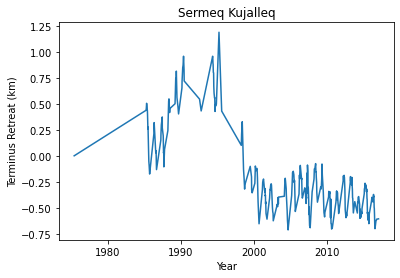

In [32]:
plt.plot(glacier0013['termpos']['t'],glacier0013['termpos']['L'])
plt.title('Sermeq Kujalleq')
plt.xlabel('Year')
plt.ylabel('Terminus Retreat (km)')
# post processing comparisons:
    # average until present day
    # average year by year
    # model termini changes 

Text(0, 0.5, 'Terminus Retreat (km)')

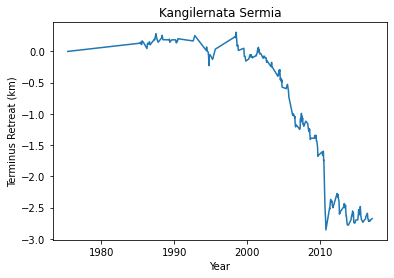

In [19]:
plt.plot(glacier0052['termpos']['t'],glacier0052['termpos']['L'])
plt.title('Kangilernata Sermia')
plt.xlabel('Year')
plt.ylabel('Terminus Retreat (km)')

Text(0, 0.5, 'Terminus Retreat (km)')

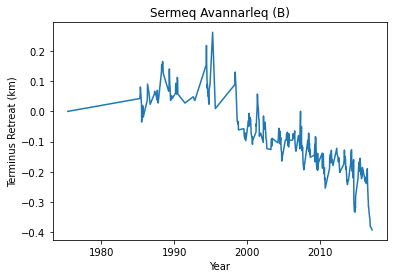

In [20]:
plt.plot(glacier0053['termpos']['t'],glacier0053['termpos']['L'])
plt.title('Sermeq Avannarleq (B)')
plt.xlabel('Year')
plt.ylabel('Terminus Retreat (km)')

Text(0, 0.5, 'Terminus Retreat (km)')

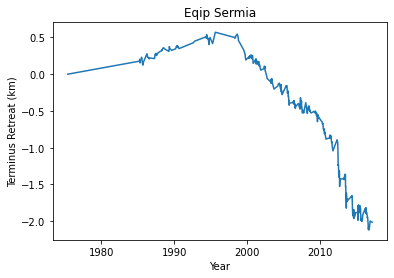

In [24]:
plt.plot(glacier0090['termpos']['t'],glacier0090['termpos']['L'])
plt.title('Eqip Sermia')
plt.xlabel('Year')
plt.ylabel('Terminus Retreat (km)')

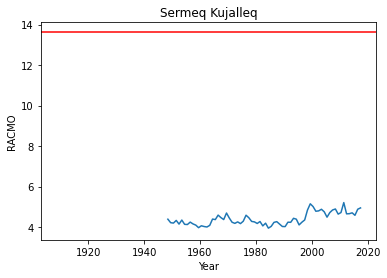

In [35]:
plt.plot(glacier0013['EN4']['t'],glacier0013['EN4']['TF'])
plt.title('Sermeq Kujalleq - EN4')
plt.xlabel('Year')
plt.ylabel('thermal forcing (TF)')
plt.axhline(y=13.62, color='r', linestyle='-')

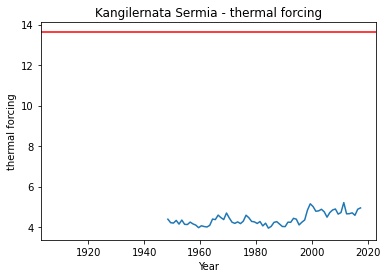

In [36]:
plt.plot(glacier0052['EN4']['t'],glacier0052['EN4']['TF'])
plt.title('Kangilernata Sermia - EN4')
plt.xlabel('Year')
plt.ylabel('thermal forcing (TF)')
plt.axhline(y=13.62, color='r', linestyle='-')

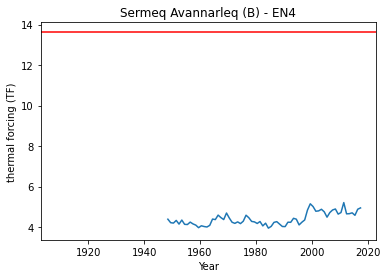

In [41]:
plt.plot(glacier0053['EN4']['t'],glacier0053['EN4']['TF'])
plt.title('Sermeq Avannarleq (B) - EN4')
plt.xlabel('Year')
plt.ylabel('thermal forcing (TF)')
plt.axhline(y=13.62, color='r', linestyle='-')

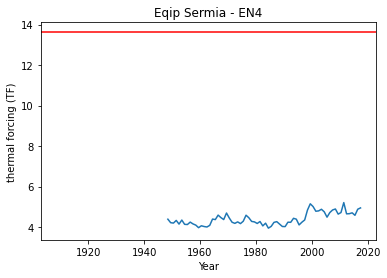

In [42]:
plt.plot(glacier0090['EN4']['t'],glacier0090['EN4']['TF'])
plt.title('Eqip Sermia - EN4')
plt.xlabel('Year')
plt.ylabel('thermal forcing (TF)')
plt.axhline(y=13.62, color='r', linestyle='-')

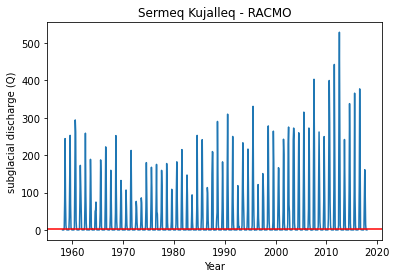

In [37]:
plt.plot(glacier0013['RACMO']['t'],glacier0013['RACMO']['Q'])
plt.title('Sermeq Kujalleq - RACMO')
plt.xlabel('Year')
plt.ylabel('subglacial discharge (Q)')
plt.axhline(y=2.65, color='r', linestyle='-')

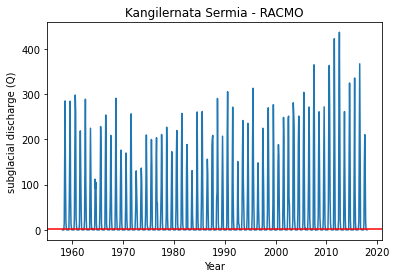

In [38]:
plt.plot(glacier0052['RACMO']['t'],glacier0052['RACMO']['Q'])
plt.title('Kangilernata Sermia - RACMO')
plt.xlabel('Year')
plt.ylabel('subglacial discharge (Q)')
plt.axhline(y=2.65, color='r', linestyle='-')

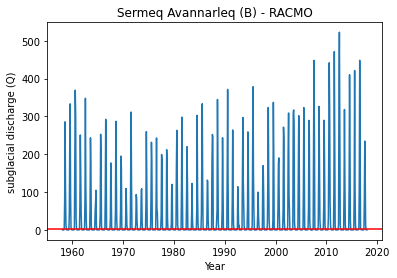

In [39]:
plt.plot(glacier0053['RACMO']['t'],glacier0053['RACMO']['Q'])
plt.title('Sermeq Avannarleq (B) - RACMO')
plt.xlabel('Year')
plt.ylabel('subglacial discharge (Q)')
plt.axhline(y=2.65, color='r', linestyle='-')

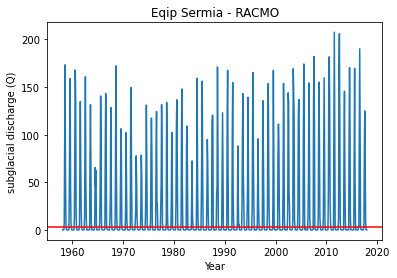

In [40]:
plt.plot(glacier0090['RACMO']['t'],glacier0090['RACMO']['Q'])
plt.title('Eqip Sermia - RACMO')
plt.xlabel('Year')
plt.ylabel('subglacial discharge (Q)')
plt.axhline(y=2.65, color='r', linestyle='-')